# Do the same thing for the UDF_f105w.fits file as for the sep_tutorial

In [1]:
import sep
from astropy.io import fits
from astropy.modeling import rotations
import numpy as np
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
%matplotlib inline

In [2]:
f105w = download_file('https://archive.stsci.edu/pub/hlsp/hudf12/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
hdul = fits.open(f105w)
data = hdul[0].data

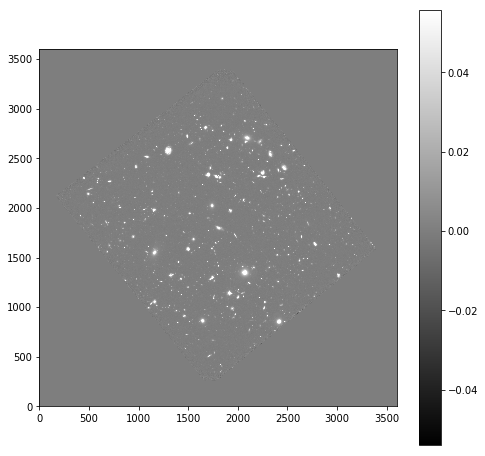

In [8]:
m, s = np.mean(data), np.std(data)
plt.figure(figsize=(8,8))
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('f105w_direct.png');

## Background Subtraction

In [ ]:
data = data.byteswap(inplace=True).newbyteorder()
bkg = sep.Background(data)

In [ ]:
print(bkg.globalback)
print(bkg.globalrms)

In [ ]:
bkg_f105w = bkg.back()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(bkg_f105w, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('f105w_back.png');

In [ ]:
bkg_rms = bkg.rms()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('f105w_rms.png');

In [ ]:
data_sub = data - bkg

## Object Detection

In [ ]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [ ]:
len(objects)

In [ ]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8,8))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),width=6*objects['a'][i],height=6*objects['b'][i],angle=objects['theta'][i]*180/(2*np.pi))
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('f105w_final.png')

## Aperature Photometry

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub,objects['x'],objects['y'],3.0,err=bkg.globalrms,gain=1.0)

In [3]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i,flux[i],fluxerr[i]))

NameError: name 'flux' is not defined